In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import requests
import seaborn as sns
import json
import sys
import os

# Import modules defined in src/
sys.path.append(os.path.abspath('../src'))
from seasonality import SeasonalPlotter

%matplotlib qt

In [ ]:
# Set seaborn theme
sns.set_theme()

# Get data

Read your personal API key

In [ ]:
with open("../api_key", "r") as file:
    API_KEY = file.read()

In [ ]:
# Define the API endpoint and parameters
url = "https://api.atmo-aura.fr/api/v1/valeurs/horaire"

data = pd.DataFrame()

for site_id in ["FR15038", "FR15043", "FR15053"]:
    params = {
        "api_token": API_KEY,
        "format": "json",
        "sites": site_id,
        "date_debut": "-2 years",
        "label_court_polluant": "PM2.5",
        "order_by_date": "asc",
    }

    # Make the GET request
    response = requests.get(url, params=params)

    response = json.loads(response.text)
    data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

    while response["links"]["next"] is not None:
        response = requests.get(response["links"]["next"])
        response = json.loads(response.text)
        data = pd.concat([data, pd.DataFrame(response["data"])], ignore_index=True)

data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.tz_localize(None)

In [ ]:
class site():
    def __init__(self, data, site_id):
        self.data = data[data["site_id"] == site_id]

        if self.data.empty:
            raise ValueError("No data available for this site")
        
        self.site_id = site_id

        self.reference_data = self.data.query("type_appareil_id == 11")
        self.reference_values = self.reference_data.loc[:, ["valeur", "date"]]

        self.microsensor_data = self.data.query("type_appareil_id == 57")
        self.microsensor_values = self.microsensor_data.loc[:, ["valeur", "date"]]

    def get_reference_data(self):
        return self.reference_data
    
    def get_microsensor_data(self):
        return self.microsensor_data
    
    def get_reference_values(self):
        return self.reference_values
    
    def get_microsensor_values(self):
        return self.microsensor_values
    
    def filter_date(self, start_date, end_date):
        reference = self.get_reference_data()
        microsensor = self.get_microsensor_data()

        reference = reference[(reference["date"] >= start_date) & (reference["date"] <= end_date)]
        microsensor = microsensor[(microsensor["date"] >= start_date) & (microsensor["date"] <= end_date)]

        return reference, microsensor
    
    def plot(self, ax = None, *, kwargs = {}):
        if ax is None:
            ax = plt.gca()

        x_ref = self.reference_values["date"]
        y_ref = self.reference_values["valeur"]

        x_micro = self.microsensor_values["date"]
        y_micro = self.microsensor_values["valeur"]

        ax.plot(x_ref, y_ref, label="Reference values")
        ax.plot(x_micro, y_micro, label="Microsensor values")
        ax.set_title(f"PM2.5 values for site {self.site_id}")
        ax.set_xlabel("Date")
        ax.set_ylabel("PM2.5 values (µg/m³)")
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
        ax.legend()
    
        return ax

In [ ]:
site_id_dict = {
    "Saint Martin d'Hères": "FR15038",
    "Les Frenes": "FR15043",
    "Rocade Sud": "FR15053",
}

LF = site(data, site_id_dict["Les Frenes"])
SMH = site(data, site_id_dict["Saint Martin d'Hères"])

# Descriptive statistics
On the SMH station

## Differences

In [ ]:
# Filter on date
reference, microsensor = SMH.filter_date("2023-01-01", "2023-12-31")
# Merge microsensor and reference data
smh_data = pd.merge(reference, microsensor, on="date")

In [ ]:
# Compute difference
smh_data["diff"] = smh_data["valeur_y"] - smh_data["valeur_x"]
# Compute absolute difference
smh_data["abs_diff"] = abs(smh_data["valeur_x"] - smh_data["valeur_y"])

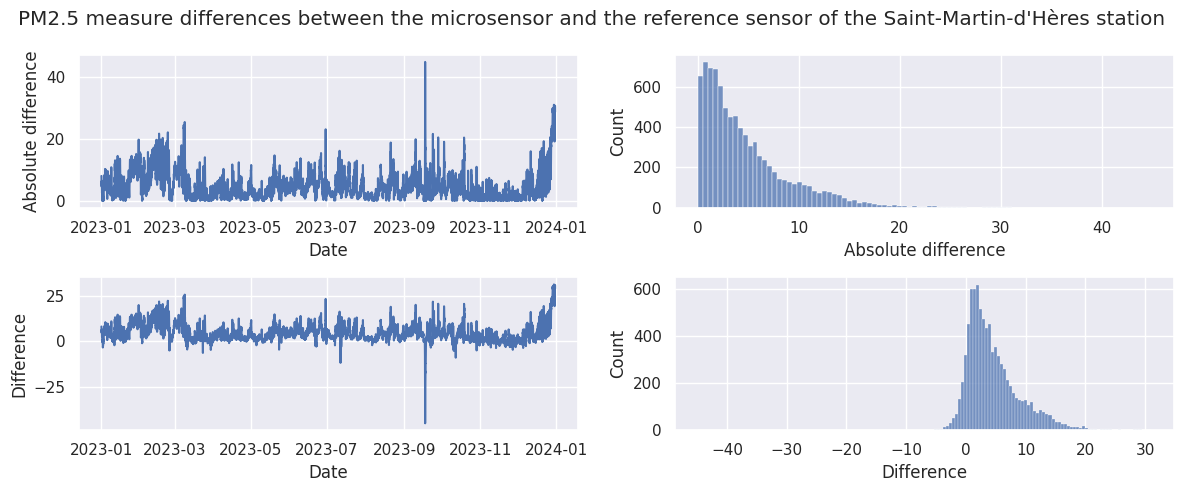

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

axes[0, 0].plot(smh_data["date"], smh_data["abs_diff"])
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Absolute difference")

sns.histplot(smh_data["abs_diff"], ax=axes[0, 1])
axes[0, 1].set_xlabel("Absolute difference")

axes[1, 0].plot(smh_data["date"], smh_data["diff"])
axes[1, 0].set_xlabel("Date")
axes[1, 0].set_ylabel("Difference")

sns.histplot(smh_data["diff"], ax=axes[1, 1])
axes[1, 1].set_xlabel("Difference")

plt.suptitle("PM2.5 measure differences between the microsensor and the reference sensor of the Saint-Martin-d'Hères station")
plt.tight_layout()
plt.show()


The microsensor of the Saint-Martin-d'Hères station overmeasures systematically the rate of PM2.5 relatively to its reference sensor.

## Rolling statistics

In [ ]:
# Compute the rolling mean
smh_data["moving_average_48_x"] = smh_data["valeur_x"].rolling(48).mean()
smh_data["moving_average_48_y"] = smh_data["valeur_y"].rolling(48).mean()
# Compute the rolling variance
smh_data["moving_variance_48_x"] = smh_data["valeur_x"].rolling(48).var()
smh_data["moving_variance_48_y"] = smh_data["valeur_y"].rolling(48).var()

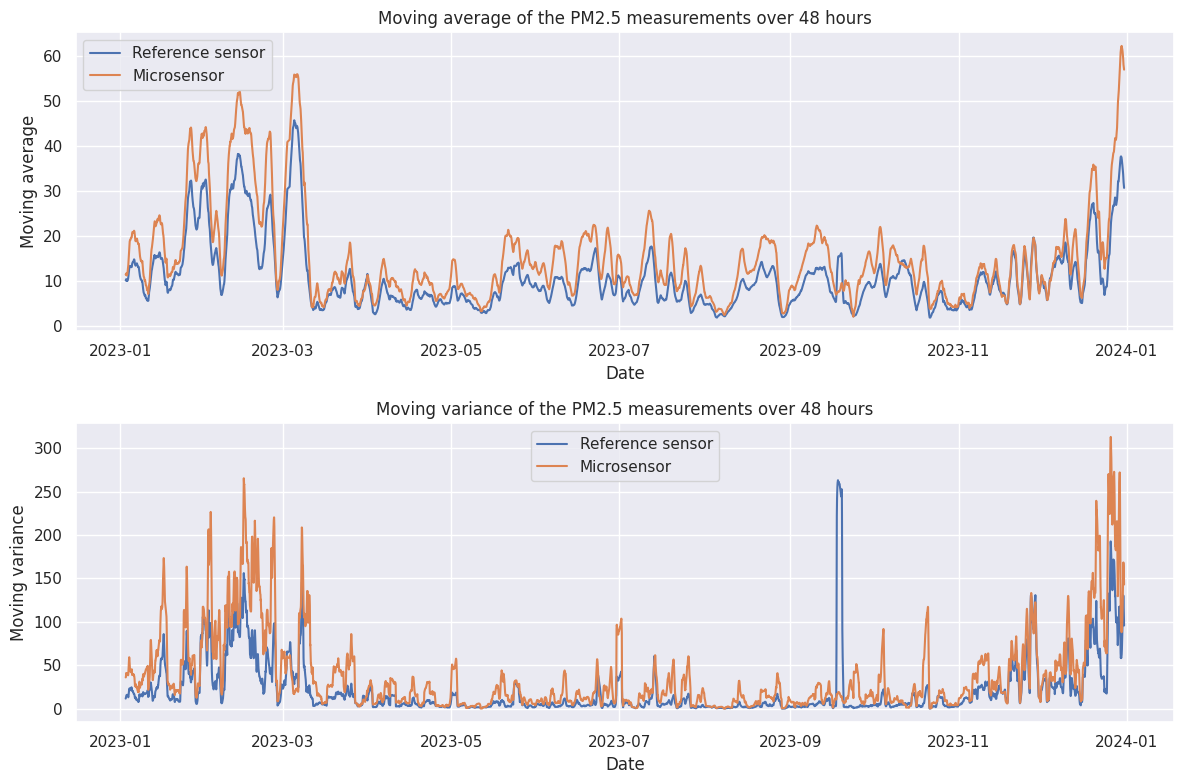

In [ ]:
_, axs = plt.subplots(2, figsize=(12, 8))

# Plot moving average
axs[0].plot(smh_data["date"], smh_data["moving_average_48_x"], label="Reference sensor")
axs[0].plot(smh_data["date"], smh_data["moving_average_48_y"], label="Microsensor")
axs[0].set_ylabel("Moving average")
axs[0].set_xlabel("Date")
axs[0].set_title("Moving average of the PM2.5 measurements over 48 hours")
axs[0].legend()

# Plot moving variance
axs[1].plot(smh_data["date"], smh_data["moving_variance_48_x"], label="Reference sensor")
axs[1].plot(smh_data["date"], smh_data["moving_variance_48_y"], label="Microsensor")
axs[1].set_ylabel("Moving variance")
axs[1].set_xlabel("Date")
axs[1].set_title("Moving variance of the PM2.5 measurements over 48 hours")
axs[1].legend()

plt.tight_layout()
plt.show()

## Seasonal plot

In [ ]:
# Copy dataframe for seasonal plot
smh_data_seasonality = smh_data.copy()

In [ ]:
# Set datetime column as index
smh_data_seasonality.set_index("date", inplace=True, drop=True)

In [ ]:
# Adapt pandas index type for passing df to the seasonal plot function
smh_data_seasonality.index = smh_data_seasonality.index.to_period("h")

In [ ]:
# Define time variables
smh_data_seasonality["dayofyear"] = smh_data_seasonality.index.dayofyear
smh_data_seasonality["hourofday"] = smh_data_seasonality.index.hour
smh_data_seasonality["monthofyear"] = smh_data_seasonality.index.month

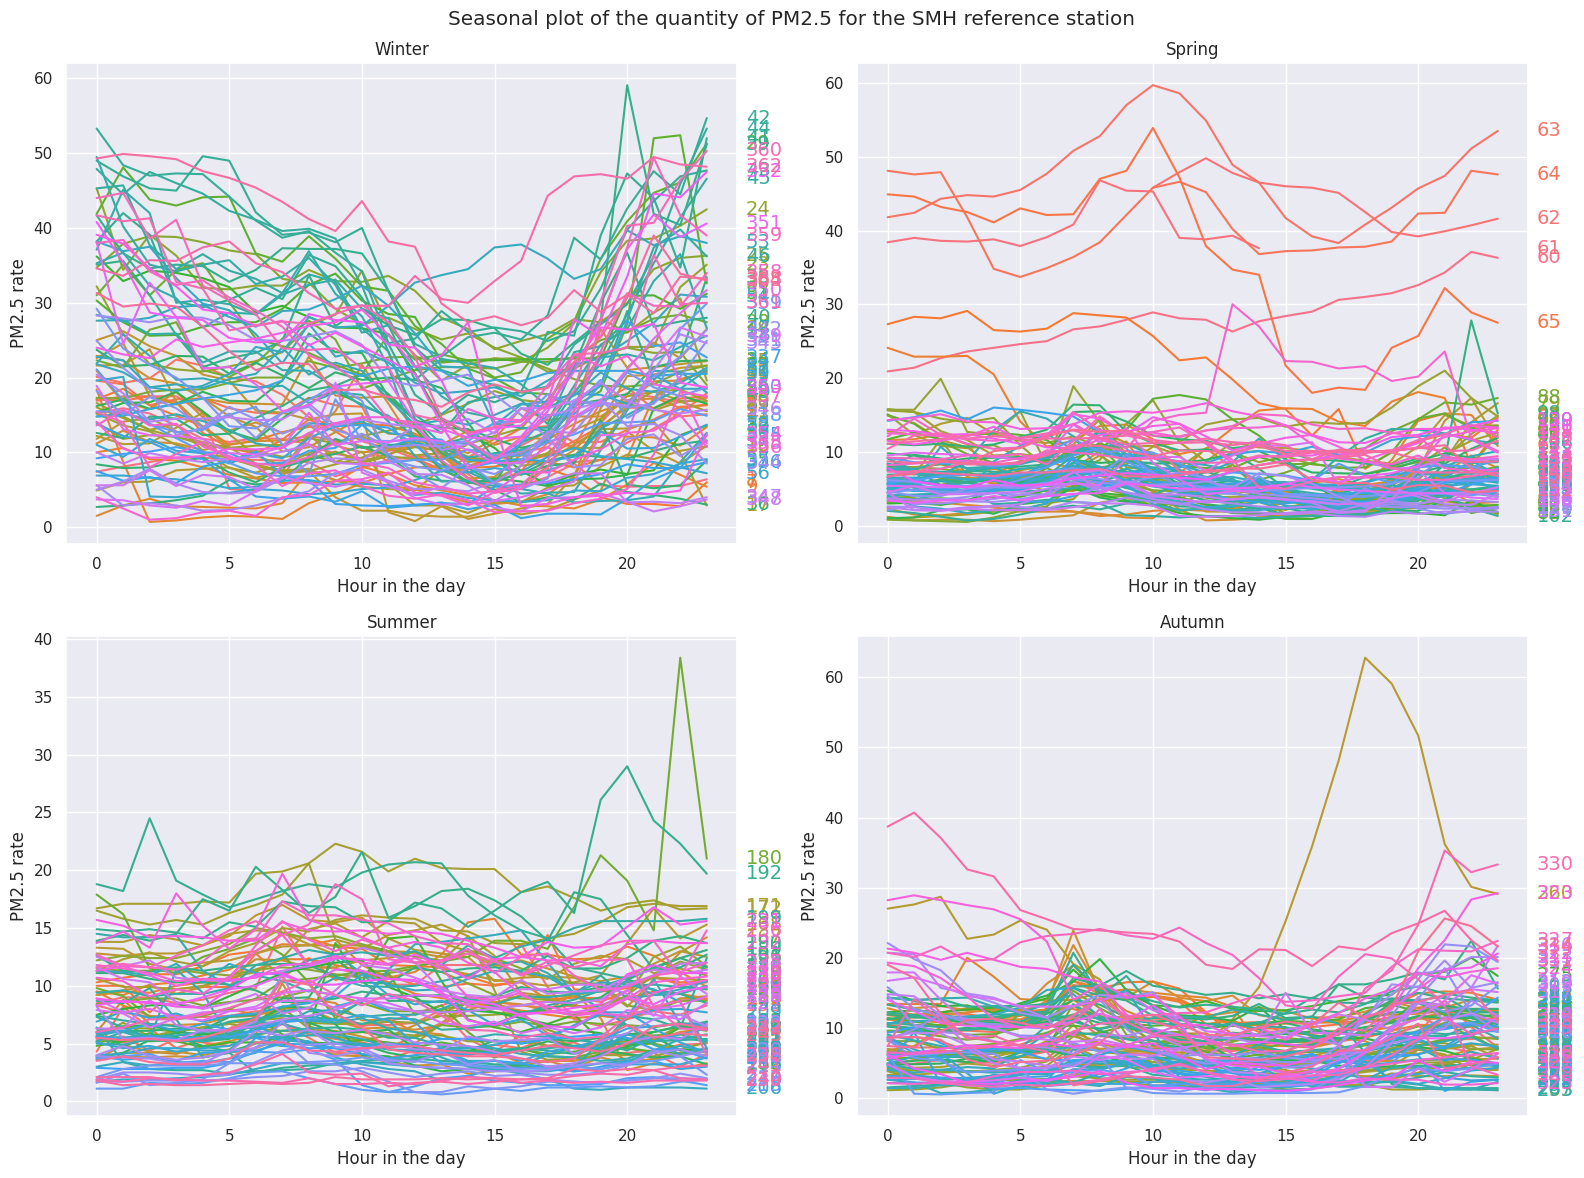

In [ ]:
# Define seasons based on months
seasons = {
    "Winter": [12, 1, 2],
    "Spring": [3, 4, 5],
    "Summer": [6, 7, 8],
    "Autumn": [9, 10, 11],
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Iterate through seasons and create plots
for i, (season, months) in enumerate(seasons.items()):
    # Filter data for the current season
    season_data = smh_data_seasonality[smh_data_seasonality["monthofyear"].isin(months)]
    
    SeasonalPlotter.seasonal_plot(
        X=season_data, 
        y="valeur_x", 
        period="dayofyear", 
        freq="hourofday", 
        ax=axes[i]
    )
    
    axes[i].set_ylabel("PM2.5 rate")
    axes[i].set_xlabel("Hour in the day")
    axes[i].set_title(season)

plt.suptitle("Seasonal plot of the quantity of PM2.5 for the SMH reference station")
plt.tight_layout()
plt.show()